In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

In [114]:
import sys
sys.path.append('..')

from utils.io import read_image, multi_rle_decode, masks_as_overlap

In [29]:
DATA_DIR = '../../data/dataset/train_overlapped/'

MASKS_DF = '../../data/dataset/train_ship_segmentations_v2.csv'
MOZAIK_DF = '../../data/dataset/mozaik.csv'

In [13]:
train_df = pd.read_csv(MASKS_DF)
mozaik_df = pd.read_csv(MOZAIK_DF)

train_ids = train_df.ImageId.unique().tolist()
train_set = set(train_ids)

In [102]:
def to_dict(masks_df):
    print('Indexing... ETA- {} sec.'.format(masks_df.shape[0] / 10000))
    masks_dict = (masks_df.fillna('')
                  .groupby('ImageId')['EncodedPixels']
                  .apply(list)
                  .to_dict())
    return masks_dict

train_dict = to_dict(train_df)

Indexing... ETA- 23.1723 sec.


In [22]:
def image_to_float(image):
    return image / 255

In [53]:
import time

In [92]:
cdf = mozaik_df.groupby('BigImageId').count()

In [95]:
cdf.sort_values('ImageId', ascending=False)

bf  brow  bcol  ImageId   row   col
BigImageId                                       
111         3754  3754  3754     3754  3754  3754
283         3087  3087  3087     3087  3087  3087
380         3051  3051  3051     3051  3051  3051
178         2304  2304  2304     2304  2304  2304
239         2032  2032  2032     2032  2032  2032
480         1729  1729  1729     1729  1729  1729
86          1710  1710  1710     1710  1710  1710
264         1583  1583  1583     1583  1583  1583
131         1582  1582  1582     1582  1582  1582
461         1437  1437  1437     1437  1437  1437
101         1386  1386  1386     1386  1386  1386
389         1354  1354  1354     1354  1354  1354
308         1276  1276  1276     1276  1276  1276
423         1252  1252  1252     1252  1252  1252
181         1250  1250  1250     1250  1250  1250
81          1153  1153  1153     1153  1153  1153
888         1095  1095  1095     1095  1095  1095
983         1081  1081  1081     1081  1081  1081
432         1063  1063  1063     1063  1063  1063
559         1016  1016  1016     1016  1016  1016
615          990   990   990      990   990   990
433          963   963   963      963   963   963
133          952   952   952      952   952   952
147          884   884   884      884   884   884
376          874   874   874      874   874   874
191          872   872   872      872   872   872
170          868   868   868      868   868   868
113          840   840   840      840   840   840
707          828   828   828      828   828   828
45           808   808   808      808   808   808
...          ...   ...   ...      ...   ...   ...
35678          1     1     1        1     1     1
27305          1     1     1        1     1     1
41904          1     1     1        1     1     1
37605          1     1     1        1     1     1
14518          1     1     1        1     1     1
27306          1     1     1        1     1     1
41903          1     1     1        1     1     1
33576          1     1     1        1     1     1
39361          1     1     1        1     1     1
7727           1     1     1        1     1     1
2949           1     1     1        1     1     1
34703          1     1     1        1     1     1
40548          1     1     1        1     1     1
5751           1     1     1        1     1     1
33639          1     1     1        1     1     1
44857          1     1     1        1     1     1
2506           1     1     1        1     1     1
39350          1     1     1        1     1     1
31134          1     1     1        1     1     1
31879          1     1     1        1     1     1
27900          1     1     1        1     1     1
8066           1     1     1        1     1     1
43277          1     1     1        1     1     1
45864          1     1     1        1     1     1
20214          1     1     1        1     1     1
749            1     1     1        1     1     1
44610          1     1     1        1     1     1
5981           1     1     1        1     1     1
43755          1     1     1        1     1     1
4419           1     1     1        1     1     1

[46127 rows x 6 columns]

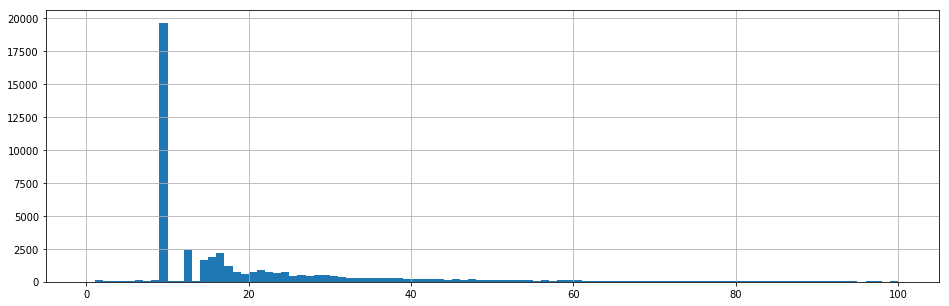

In [86]:
plt.figure(figsize=(16,5))
cdf.hist(bins=100, range=(0, 100))
plt.show()

In [120]:
def read_big_image(bimage_id):
    
    # fetch ids
    # df1 = mozaik_df[(mozaik_df.BigImageId==bimage_id) & (mozaik_df.brow < 15) & (mozaik_df.bcol < 15)].sort_values(by='ImageId') # limit size to 2560 x 2560
    df1 = mozaik_df[mozaik_df.BigImageId==bimage_id].sort_values(by='ImageId')
    nrows, ncols = df1[['brow', 'bcol']].max(axis=0) + [1, 1]
    
    dest_image = np.zeros((int(nrows*256), int(ncols*256), 3), dtype=np.uint8)
    dest_mask = np.zeros((int(nrows*256), int(ncols*256), 3), dtype=np.uint8)
    
    image = None
    image_id = -1
    
    for _, r in df1.iterrows():
        if r.ImageId != image_id:
            image_id = r.ImageId
            path = os.path.join(DATA_DIR, image_id)
            image = read_image(path)
            
            mask = multi_rle_decode(train_dict[image_id], image.shape[:2]).clip(0, 1)
            border = masks_as_overlap(train_dict[image_id], image.shape[:2]).clip(0, 1)
            mask -= border
            
        dx, dy = r.bcol * 256, r.brow * 256
        sx, sy = r.col * 256, r.row * 256
        
        dest_image[dy:dy+256,dx:dx+256,:] = image[sy:sy+256,sx:sx+256,:]
        dest_mask[dy:dy+256,dx:dx+256,:] = mask[sy:sy+256,sx:sx+256,:]


    return dest_image, dest_mask * 255

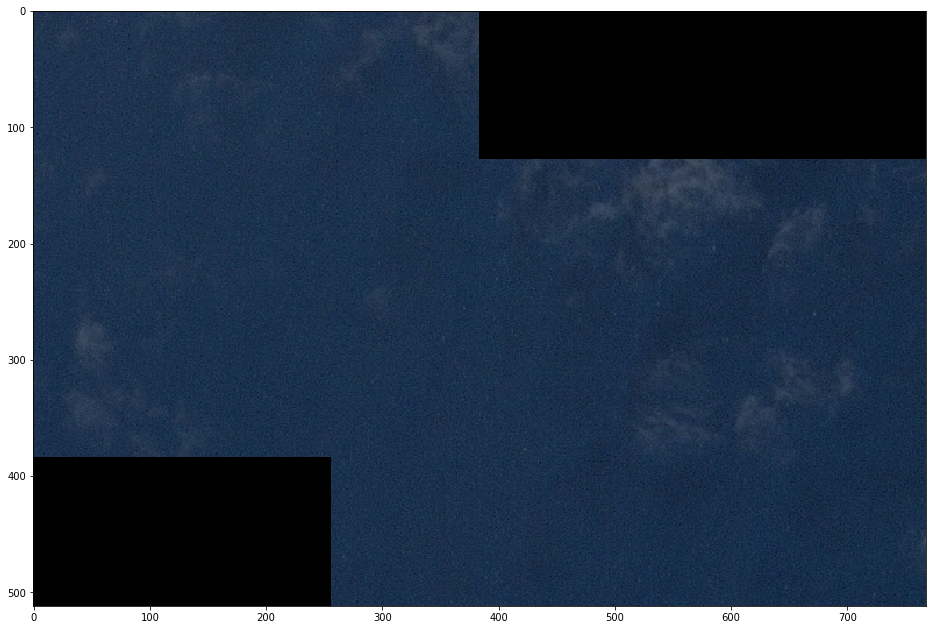

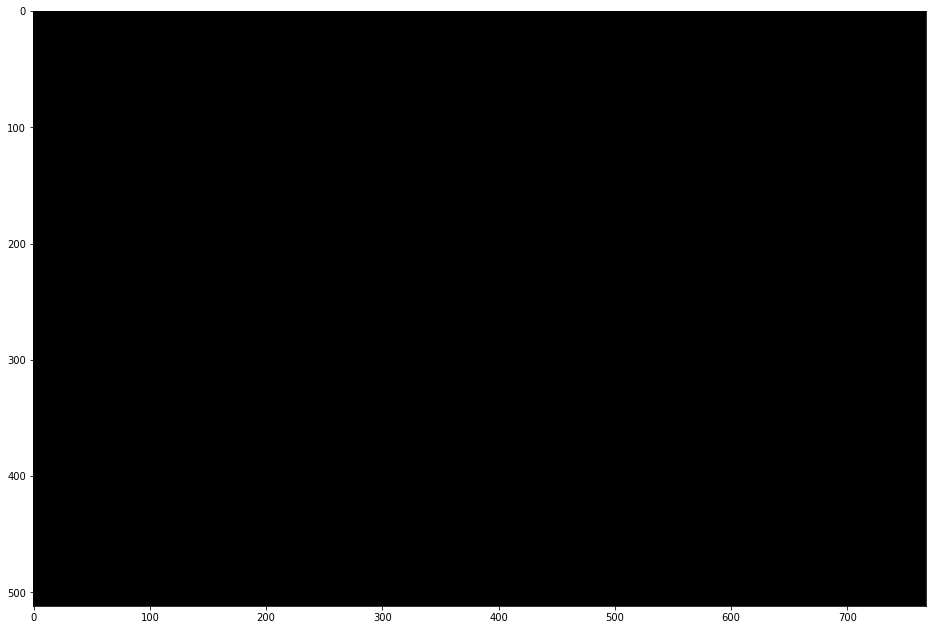

CPU times: user 1.26 s, sys: 52 ms, total: 1.32 s
Wall time: 1.37 s


In [127]:
%%time
bimg, bmask = read_big_image(0)

plt.figure(figsize=(16,16))
plt.imshow(bimg[::2, ::2])
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(bmask[::2, ::2])
plt.show()

In [126]:
DST_DIR_I = '../../data/dataset/train_mozaik/images/'
DST_DIR_M = '../../data/dataset/train_mozaik/masks/'

os.makedirs(DST_DIR_I)
os.makedirs(DST_DIR_M)

In [144]:
#for i in tqdm(range(len(mozaik_df.BigImageId.unique()))):
for i in tqdm(range(10000)):
    bimg, bmask = read_big_image(i)
    
    cv2.imwrite(os.path.join(DST_DIR_I, '{:06d}.jpg'.format(i)), bimg[..., ::-1])
    cv2.imwrite(os.path.join(DST_DIR_M, '{:06d}.png'.format(i)), bmask)
    
#     if i > 10:
#          break

A Jupyter Widget